In [1]:
import pandas as pd
from adjustText import adjust_text
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
sns.set_palette("muted")
sns.set(font_scale = 1.5)
systems = ['clickhouse', 'duckdb', 'hyper', 'monetdb'] # 'gnu', 'umbra'
markers = ['x' for _ in range(len(systems))]
sfs = [1, 10] # 100, 300

In [3]:
def system_case(s):
    if s == 'duckdb':
        return 'DuckDB'
    elif s == 'clickhouse':
        return 'ClickHouse'
    elif s == 'monetdb':
        return 'MonetDB'
    elif s == 'hyper':
        return 'HyPer'
    elif s == 'gnu':
        return 'GNU'
    else:
        return s

In [4]:
def collect_randints(systems):
    dfs = []
    for system in systems:
        df = pd.read_csv(f'../results/{system}/randints/results.csv', header=None, names=['query', 'time'])
        df['system'] = system
        dfs.append(df)
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [5]:
def annotate(ax, systems_and_colors):
    systems = [s for (s, c) in systems_and_colors]
    colors = [c for (s, c) in systems_and_colors]
    for coll, s, c in zip(ax.collections, systems, colors):
        of = coll.get_offsets()[-1]
        label_of = (ax.get_xlim()[1], of[1] - ax.get_ylim()[1] * 0.02)
        ax.annotate(s, label_of, c=c)

In [6]:
randints_df = collect_randints(systems)

asc_desc_df = randints_df[(randints_df['query'] == '100_asc') | (randints_df['query'] == '100_desc') | (randints_df['query'] == '100')]
asc_desc_df = asc_desc_df.groupby(['system', 'query']).median().reset_index().sort_values('system')

randints_df = randints_df[(randints_df['query'] != '100_asc') & (randints_df['query'] != '100_desc')]
randints_df['query'] = pd.to_numeric(randints_df['query'])
randints_df['query'] = randints_df['query'].apply(lambda q: 10 * q)
randints_df = randints_df.groupby(['system', 'query']).median().reset_index().sort_values('system')

In [7]:
systems_and_colors = list(zip(list(randints_df['system'].unique()), sns.color_palette()[:len(systems)]))

/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.3333333333333333, 0.6588235294117647, 0.40784313725490196)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior ma

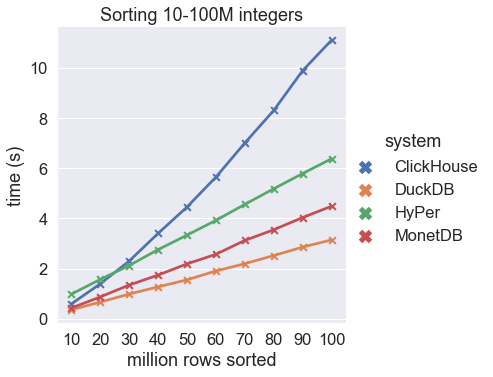

In [8]:
plot = sns.catplot(data=randints_df, kind='point', markers=markers, x='query', y='time', hue='system')
plot.ax.set_title('Sorting 10-100M integers')
plt.xlabel('million rows sorted')
plt.ylabel('time (s)')
plot.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda q, pos: f'{10*(q+1)}'))
for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
plt.savefig('saved_figs/randints_scaling.svg', bbox_inches="tight")

In [9]:
def collect_randints_threads(systems):
    dfs = []
    for system in systems:
        df = pd.read_csv('../results/duckdb/randints_threads/results.csv', header=None, names=['threads', 'time'])
        df['system'] = system
        dfs.append(df)
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [10]:
threads_df = collect_randints_threads(['duckdb'])
threads_df = threads_df.groupby(['system', 'threads']).median().reset_index().sort_values('system')

/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


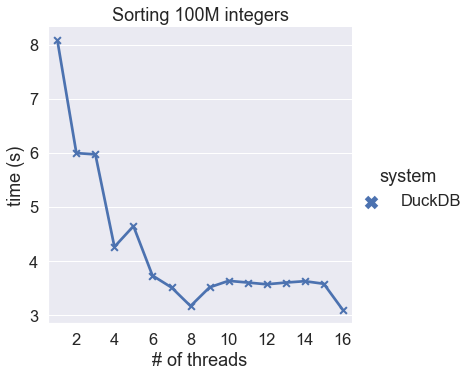

In [11]:
plot = sns.catplot(data=threads_df, kind='point', markers=markers, x='threads', y='time', hue='system')
plot.ax.set_title('Sorting 100M integers')
plt.xlabel('# of threads')
plt.ylabel('time (s)')
for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
for ind, label in enumerate(plot.axes[0][0].get_xticklabels()):
    label.set_visible(ind % 2 == 1)
plt.savefig('saved_figs/randints_threads.svg', bbox_inches="tight")

In [12]:
paired = sns.color_palette('Paired')
barplot_colors = paired[7:8] + paired[2:4]

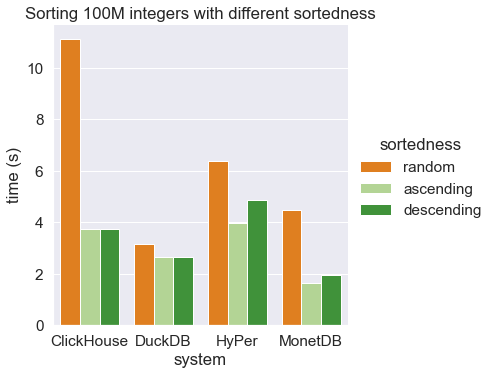

In [23]:
sns.set(font_scale = 1.4)
plot = sns.catplot(data=asc_desc_df, kind='bar', x='system', y='time', hue='query', palette=sns.color_palette(barplot_colors))
plt.ylabel('time (s)')
plot.ax.set_title('Sorting 100M integers with different sortedness')
plot._legend.set_title('sortedness')
plot._legend.texts[0].set_text('random')
plot._legend.texts[1].set_text('ascending')
plot._legend.texts[2].set_text('descending')
plot._legend._legend_box.set_offset((360, 225))
plt.savefig('saved_figs/randints_sortedness.svg', bbox_inches="tight")

In [14]:
sns.set(font_scale = 1.7)

In [15]:
def collect_tpcds_customer(systems, sfs):
    dfs = []
    for system in systems:
        for sf in sfs:
            df = pd.read_csv(f'../results/{system}/tpcds/sf{sf}/customer/results.csv', header=None, names=['query', 'time'])
            df['system'] = system
            df['sf'] = sf
            dfs.append(df)
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [16]:
customer_df = collect_tpcds_customer(systems, sfs)

customer_int_df = customer_df[customer_df['query'].str.contains('int')].reset_index(drop=True)
customer_int_df['query'] = customer_int_df['query'].apply(lambda q: q.replace('int', ''))
customer_int_df['query'] = pd.to_numeric(customer_int_df['query'])
customer_int_df = customer_int_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

customer_varchar_df = customer_df[customer_df['query'].str.contains('varchar')].reset_index(drop=True)
customer_varchar_df['query'] = customer_varchar_df['query'].apply(lambda q: q.replace('varchar', ''))
customer_varchar_df['query'] = pd.to_numeric(customer_varchar_df['query'])
customer_varchar_df = customer_varchar_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.3333333333333333, 0.6588235294117647, 0.40784313725490196)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior ma

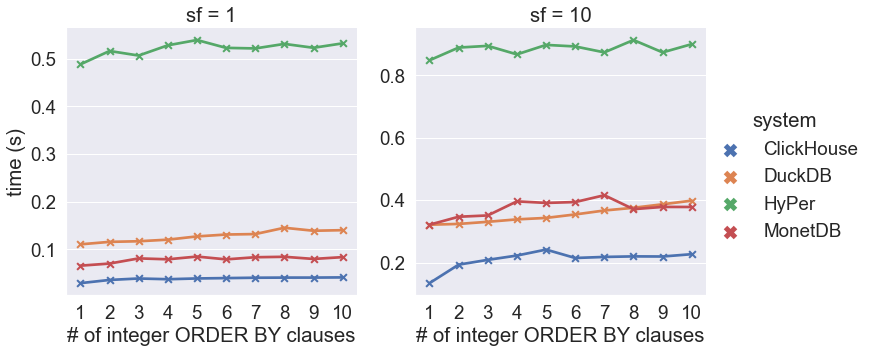

In [17]:
plot = sns.catplot(data=customer_int_df, col='sf', kind='point', markers=markers, x='query', y='time', hue='system', sharey=False, sharex=True)
plot.axes[0][0].set_ylabel('time (s)')
for sf in range(len(sfs)):
    ax = plot.axes[0][sf]
    ax.set_xlabel('# of integer ORDER BY clauses')
    if sf > 0:
        ax.set_ylabel('')
for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
plt.savefig('saved_figs/tpcds_customer_int.svg', bbox_inches="tight")

/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.3333333333333333, 0.6588235294117647, 0.40784313725490196)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior ma

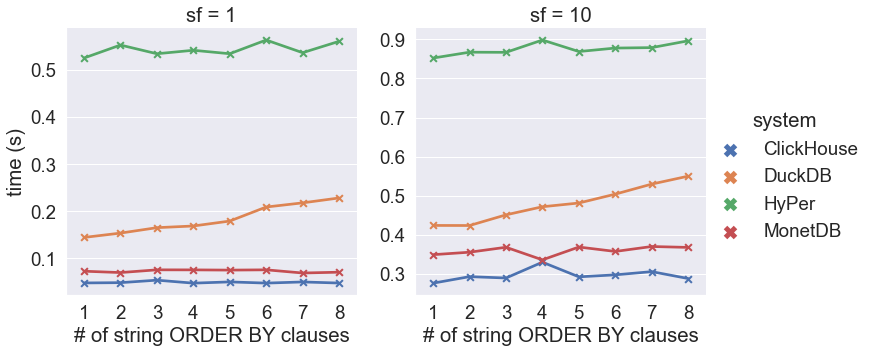

In [18]:
plot = sns.catplot(data=customer_varchar_df, col='sf', kind='point', markers=markers, x='query', y='time', hue='system', sharey=False, sharex=True)
plot.axes[0][0].set_ylabel('time (s)')
for sf in range(2):
    plot.axes[0][sf].set_xlabel('# of string ORDER BY clauses')
    if sf > 0:
        plot.axes[0][sf].set_ylabel('')
for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
plt.savefig('saved_figs/tpcds_customer_string.svg', bbox_inches="tight")

In [19]:
def collect_tpcds_catalog_sales(systems, sfs):
    dfs = []
    for system in systems:
        for sf in sfs:
            df = pd.read_csv(f'../results/{system}/tpcds/sf{sf}/catalog_sales/results.csv', header=None, names=['query', 'time'])
            df['system'] = system
            df['sf'] = sf
            dfs.append(df)
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [20]:
catalog_sales_df = collect_tpcds_catalog_sales(systems, sfs)

catalog_sales_payload_df = catalog_sales_df[catalog_sales_df['query'].str.contains('payload')].reset_index(drop=True)
catalog_sales_payload_df['query'] = catalog_sales_payload_df['query'].apply(lambda q: q.replace('payload', ''))
catalog_sales_payload_df['query'] = pd.to_numeric(catalog_sales_payload_df['query'])
catalog_sales_payload_df = catalog_sales_payload_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

catalog_sales_sorting_df = catalog_sales_df[catalog_sales_df['query'].str.contains('sorting')].reset_index(drop=True)
catalog_sales_sorting_df['query'] = catalog_sales_sorting_df['query'].apply(lambda q: q.replace('sorting', ''))
catalog_sales_sorting_df['query'] = pd.to_numeric(catalog_sales_sorting_df['query'])
catalog_sales_sorting_df = catalog_sales_sorting_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.3333333333333333, 0.6588235294117647, 0.40784313725490196)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior ma

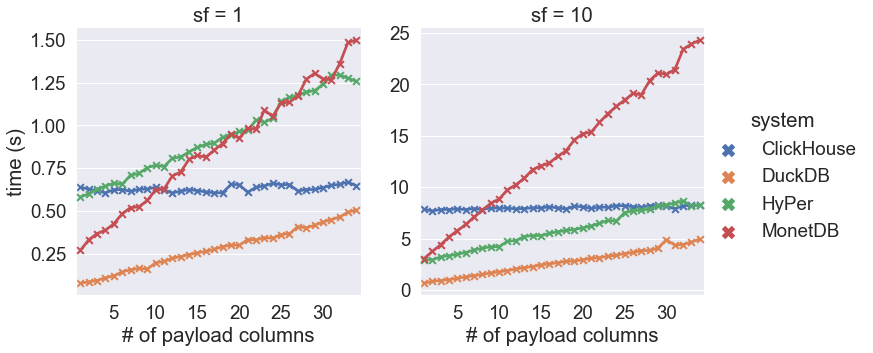

In [21]:
plot = sns.catplot(data=catalog_sales_payload_df, col='sf', kind='point', markers=markers, x='query', y='time', hue='system', sharey=False, sharex=True)
plot.axes[0][0].set_ylabel('time (s)')
for sf in range(2):
    plot.axes[0][sf].set_xlabel('# of payload columns')
    if sf > 0:
        plot.axes[0][sf].set_ylabel('')
    for ind, label in enumerate(plot.axes[0][sf].get_xticklabels()):
        label.set_visible(ind % 5 == 4)
for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
plt.savefig('saved_figs/tpcds_catalog_sales_payload.svg', bbox_inches="tight")

/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.3333333333333333, 0.6588235294117647, 0.40784313725490196)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior ma

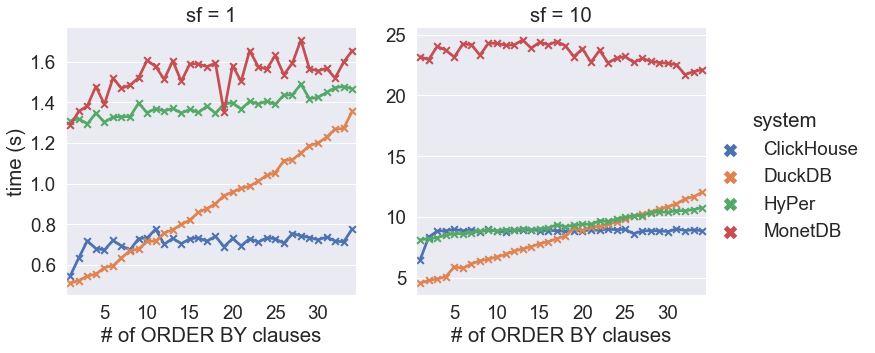

In [22]:
plot = sns.catplot(data=catalog_sales_sorting_df, col='sf', kind='point', markers=markers, x='query', y='time', hue='system', sharey=False, sharex=True)
plot.axes[0][0].set_ylabel('time (s)')
for sf in range(2):
    plot.axes[0][sf].set_xlabel('# of ORDER BY clauses')
    if sf > 0:
        plot.axes[0][sf].set_ylabel('')
    for ind, label in enumerate(plot.axes[0][sf].get_xticklabels()):
        label.set_visible(ind % 5 == 4)
for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
plt.savefig('saved_figs/tpcds_catalog_sales_sorting.svg', bbox_inches="tight")